# How do household demographics affect turnout?
__Group 28__: Zijian Wan, Zhe Li, John O'Brien, Selin Karabulut

Turning out to vote and who turns out matter. But what affects voter turnout? Do socieconomic factors such as age, gender, education, ethnicity and household income impact turnout? In this notebook, we conducted exploratory data analysis for Arizona, Massachusetts and North Dakota. 

In [1]:
# load AZ data
dfaz = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat135-voter-file/VM2Uniform/VM2Uniform--AZ--2021-05-20.tab")

In [2]:
# Read MA data
dfma = spark.read\
       .format("csv")\
       .option("header", "true")\
       .option("nullValue", "NA")\
       .option("delimiter", "\t")\
       .option("inferSchema", "true")\
       .load("gs://pstat235-sk/notebooks/jupyter/project/VM2Uniform--MA--2021-01-19.tab")

In [3]:
# load ND data
dfnd = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat235-sk/notebooks/jupyter/project/VM2Uniform--ND--2021-03-18.tab")


## Arizona
#### Variables of Interest

* ElectionReturns_G08CountyTurnoutAllRegisteredVoters
* ElectionReturns_G10CountyTurnoutAllRegisteredVoters
* ElectionReturns_G12CountyTurnoutAllRegisteredVoters
* ElectionReturns_G14CountyTurnoutAllRegisteredVoters
* ElectionReturns_G16CountyTurnoutAllRegisteredVoters
* ElectionReturns_G18CountyTurnoutAllRegisteredVoters
* CommercialData_EstimatedHHIncome
* CommercialData_EstHomeValue
* Ethnic_Description
* EthnicGroups_EthnicGroup1Desc
* Voters_Age
* Voters_Gender
* CommercialData_Education
* County
* Voters_FIPS


Turnout data is at the county level and socioeconomic indicators are at individual level. As a next step, we will aggregate individual level data up to county level using variables like 'County' and 'Voters_FIPS'

In [4]:
# count rows 
dfaz.count()

4266400

In [4]:
#  a list of columns
dfaz.columns

['SEQUENCE',
 'LALVOTERID',
 'Voters_Active',
 'Voters_StateVoterID',
 'Voters_CountyVoterID',
 'VoterTelephones_LandlineAreaCode',
 'VoterTelephones_Landline7Digit',
 'VoterTelephones_LandlineFormatted',
 'VoterTelephones_LandlineUnformatted',
 'VoterTelephones_LandlineConfidenceCode',
 'VoterTelephones_CellPhoneOnly',
 'VoterTelephones_CellPhoneFormatted',
 'VoterTelephones_CellPhoneUnformatted',
 'VoterTelephones_CellConfidenceCode',
 'Voters_FirstName',
 'Voters_MiddleName',
 'Voters_LastName',
 'Voters_NameSuffix',
 'Residence_Addresses_AddressLine',
 'Residence_Addresses_ExtraAddressLine',
 'Residence_Addresses_City',
 'Residence_Addresses_State',
 'Residence_Addresses_Zip',
 'Residence_Addresses_ZipPlus4',
 'Residence_Addresses_HouseNumber',
 'Residence_Addresses_PrefixDirection',
 'Residence_Addresses_StreetName',
 'Residence_Addresses_Designator',
 'Residence_Addresses_SuffixDirection',
 'Residence_Addresses_ApartmentNum',
 'Residence_Addresses_ApartmentType',
 'Residence_Addr

In [5]:
# inspect a column 'ElectionReturns_G08CountyTurnoutAllRegisteredVoters'
dfaz.describe(["ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]).na.drop().show()

+-------+---------------------------------------------------+
|summary|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+-------+---------------------------------------------------+
|  count|                                            4266400|
|    min|                                                53%|
|    max|                                                76%|
+-------+---------------------------------------------------+



In [6]:
# to check missingness and how many
dfaz.where(dfaz["ElectionReturns_G08CountyTurnoutAllRegisteredVoters"].isNull()).count()

0

In [7]:
# inspect a column 'CommercialData_EstimatedHHIncome'
dfaz.describe(["CommercialData_EstimatedHHIncome"]).show()

+-------+--------------------------------+
|summary|CommercialData_EstimatedHHIncome|
+-------+--------------------------------+
|  count|                         4094069|
|   mean|                            null|
| stddev|                            null|
|    min|                     $1000-14999|
|    max|                    $75000-99999|
+-------+--------------------------------+



In [8]:
# to check missingness and how many
dfaz.where(dfaz["CommercialData_EstimatedHHIncome"].isNull()).count()

172331

In [7]:
# get the unique categories in the "CommercialData_EstimatedHHIncome" column
dfaz.groupby(["CommercialData_EstimatedHHIncome"]).count().show()

+--------------------------------+-------+
|CommercialData_EstimatedHHIncome|  count|
+--------------------------------+-------+
|                  $175000-199999| 121465|
|                        $250000+| 145239|
|                     $1000-14999|  97947|
|                  $100000-124999| 473065|
|                    $75000-99999| 804277|
|                            null| 172331|
|                  $125000-149999| 321756|
|                    $25000-34999| 219944|
|                  $200000-249999| 105426|
|                    $50000-74999|1049164|
|                  $150000-174999| 145950|
|                    $35000-49999| 486644|
|                    $15000-24999| 123192|
+--------------------------------+-------+



In [10]:
# replace null values in the "CommercialData_EstimatedHHIncome" column with the string "unknown"
dfaz = dfaz.na.fill("unknown", subset=["CommercialData_EstimatedHHIncome"])

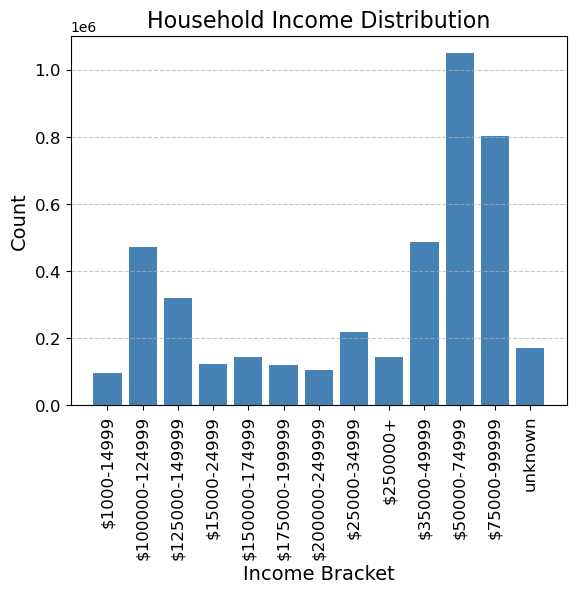

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
# convert the PySpark DataFrame to a Pandas DataFrame
dfazi_pd = dfaz.select("CommercialData_EstimatedHHIncome").toPandas()

# group by income bracket and get the count of each group
grouped = dfazi_pd.groupby("CommercialData_EstimatedHHIncome").size().reset_index(name='count')

# sort the groups by income bracket
grouped = grouped.sort_values("CommercialData_EstimatedHHIncome")

# set the color of the bars
bar_color = "steelblue"

# create a bar plot of the income brackets and their counts
plt.bar(grouped["CommercialData_EstimatedHHIncome"], grouped["count"], color=bar_color)

# add a title and labels to the plot
plt.title("Household Income Distribution", fontsize=16)
plt.xlabel("Income Bracket", fontsize=14)
plt.ylabel("Count", fontsize=14)

# adjust the font size of the axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# rotate the x-axis labels to avoid overlapping
plt.xticks(rotation=90)

# add a grid to the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# add a background color to the plot
plt.rcParams['axes.facecolor'] = '#f2f2f2'

# increase the size of the plot
plt.rcParams['figure.figsize'] = [12, 6]

# show the plot
plt.show()

In [13]:
# inspect a column 'CommercialData_EstHomeValue'
dfaz.describe(["CommercialData_EstHomeValue"]).show()

+-------+---------------------------+
|summary|CommercialData_EstHomeValue|
+-------+---------------------------+
|  count|                    4066567|
|   mean|                       null|
| stddev|                       null|
|    min|                    $100000|
|    max|                    $999983|
+-------+---------------------------+



In [14]:
# replace null values in the "CommercialData_EstHomeValue" column with the string "unknown"
dfaz = dfaz.na.fill("unknown", subset=["CommercialData_EstHomeValue"])

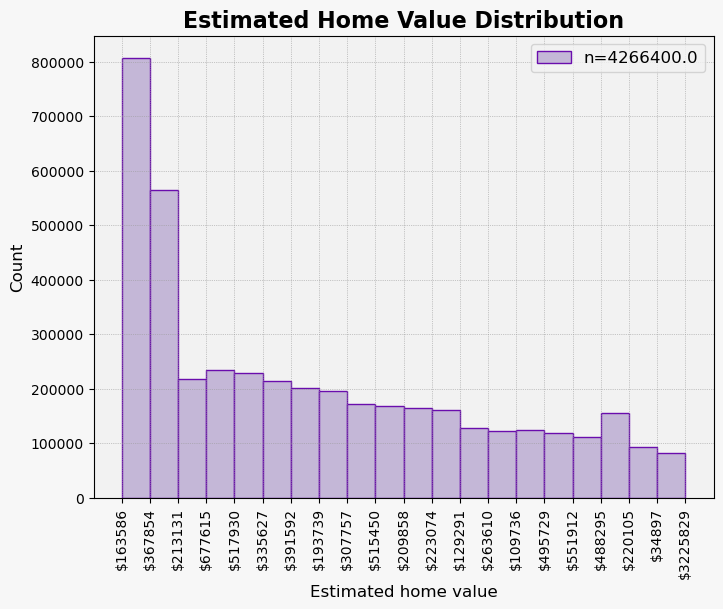

In [15]:
# convert the PySpark DataFrame to a Pandas DataFrame
dfazesth_pd = dfaz.select("CommercialData_EstHomeValue").toPandas()

# set the figure size and background color
fig = plt.figure(figsize=(8, 6), facecolor="#f7f7f7")

# create a histogram of the Voter_Age distribution
n, bins, patches = plt.hist(dfazesth_pd["CommercialData_EstHomeValue"], bins=20, edgecolor="#6a0dad", color="#c4b7d7")

# add a title and labels to the plot
plt.title("Estimated Home Value Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Estimated home value", fontsize=12)
plt.ylabel("Count", fontsize=12)

# customize the x and y ticks
plt.xticks(bins, fontsize=10)
plt.yticks(fontsize=10)

# rotate the x-axis labels to a 90 degree angle
plt.xticks(rotation=90)

# add a grid
plt.grid(linestyle="dotted", linewidth=0.5, color="#999999")

# add a legend
legend_text = f"n={sum(n)}"  # total count of voters
plt.legend([legend_text], fontsize=12, loc="upper right")

# show the plot
plt.show()

In [8]:
# inspect a column 'Ethnic_Description'
dfaz.select(["Ethnic_Description"]).na.drop().show()

+------------------+
|Ethnic_Description|
+------------------+
|     English/Welsh|
|     English/Welsh|
|     English/Welsh|
|     English/Welsh|
|            Polish|
|     English/Welsh|
|            French|
|     English/Welsh|
|     English/Welsh|
|     English/Welsh|
|     English/Welsh|
|         Slovakian|
|            French|
|     English/Welsh|
|             Scots|
|            German|
|          Hispanic|
|     English/Welsh|
|     English/Welsh|
|           Swedish|
+------------------+
only showing top 20 rows



In [9]:
# get the unique categories in the "EthnicGroups_EthnicGroup1Desc" column
dfaz.select(["EthnicGroups_EthnicGroup1Desc"]).distinct().show()

+-----------------------------+
|EthnicGroups_EthnicGroup1Desc|
+-----------------------------+
|         East and South Asian|
|                     European|
|                         null|
|                        Other|
|         Likely African-Am...|
|         Hispanic and Port...|
+-----------------------------+



In [18]:
# inspect a column 'Voters_Age'
dfaz.describe(["Voters_Age"]).show()

+-------+------------------+
|summary|        Voters_Age|
+-------+------------------+
|  count|           4263282|
|   mean|50.750146952512175|
| stddev|19.252107428381976|
|    min|                18|
|    max|                99|
+-------+------------------+



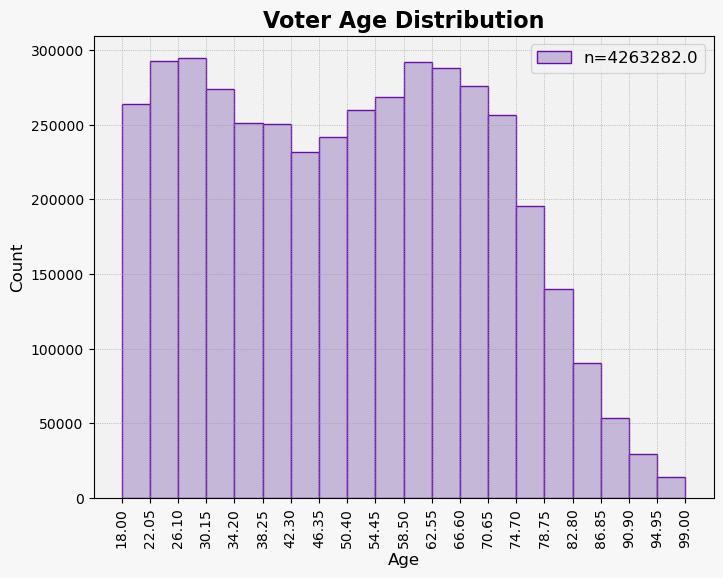

In [19]:
# convert the PySpark DataFrame to a Pandas DataFrame
dfaz_pd = dfaz.select("Voters_Age").toPandas()

# set the figure size and background color
fig = plt.figure(figsize=(8, 6), facecolor="#f7f7f7")

# create a histogram of the Voter_Age distribution
n, bins, patches = plt.hist(dfaz_pd["Voters_Age"], bins=20, edgecolor="#6a0dad", color="#c4b7d7")

# add a title and labels to the plot
plt.title("Voter Age Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)

# customize the x and y ticks
plt.xticks(bins, fontsize=10)
plt.yticks(fontsize=10)

# rotate the x-axis labels to a 90 degree angle
plt.xticks(rotation=90)

# add a grid
plt.grid(linestyle="dotted", linewidth=0.5, color="#999999")

# add a legend
legend_text = f"n={sum(n)}"  # total count of voters
plt.legend([legend_text], fontsize=12, loc="upper right")

# show the plot
plt.show()

In [20]:
# inspect a column 'Voters_Gender'
dfaz.describe(["Voters_Gender"]).show()

+-------+-------------+
|summary|Voters_Gender|
+-------+-------------+
|  count|      4243581|
|   mean|         null|
| stddev|         null|
|    min|            F|
|    max|            M|
+-------+-------------+



In [21]:
# replace null values in the "Voters_Gender" column with the string "unknown"
dfaz = dfaz.na.fill("unknown", subset=["Voters_Gender"])


In [22]:
gaz_counts = dfaz.groupBy("Voters_Gender").count()
gaz_counts.show()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|2199156|
|      unknown|  22819|
|            M|2044425|
+-------------+-------+



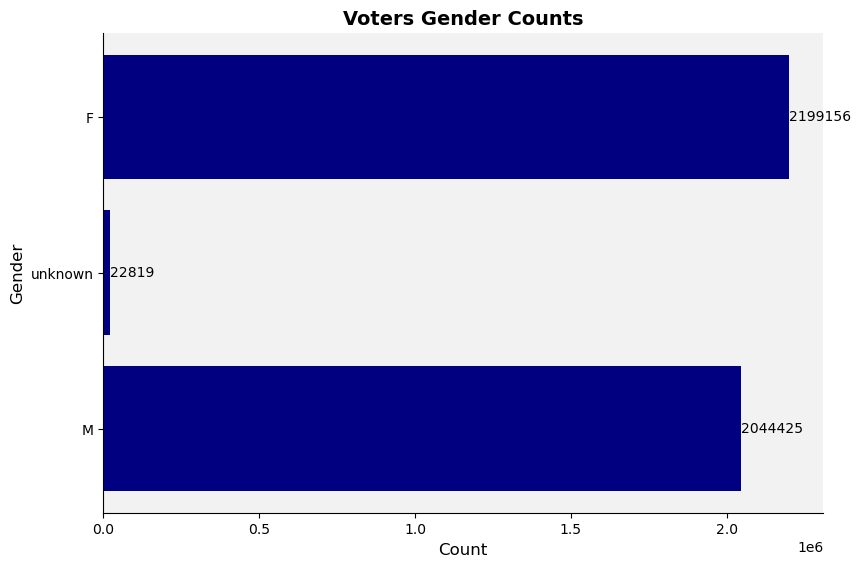

In [23]:
#plot gender
# convert the PySpark DataFrame to a Pandas DataFrame
gaz_counts_pd = gaz_counts.toPandas()

# create a horizontal bar plot of the category counts
plt.barh(gaz_counts_pd["Voters_Gender"], gaz_counts_pd["count"], color="navy")

# add a title and labels to the plot
plt.title("Voters Gender Counts", fontsize=14, fontweight="bold")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Gender", fontsize=12)

# invert the y-axis to show categories in descending order
plt.gca().invert_yaxis()

# remove the top and right spines of the plot
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# add text labels for the counts on each bar
for i, count in enumerate(gaz_counts_pd["count"]):
    plt.text(count+10, i, str(count), va="center", fontsize=10)

# adjust the spacing between the bars and the y-axis labels
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)

# show the plot
plt.show()

In [24]:
# inspect a column 'CommercialData_Education'
dfaz.describe(["CommercialData_Education"]).show()

+-------+------------------------+
|summary|CommercialData_Education|
+-------+------------------------+
|  count|                 2282066|
|   mean|                    null|
| stddev|                    null|
|    min|    Bach Degree - Ext...|
|    max|    Vocational Techni...|
+-------+------------------------+



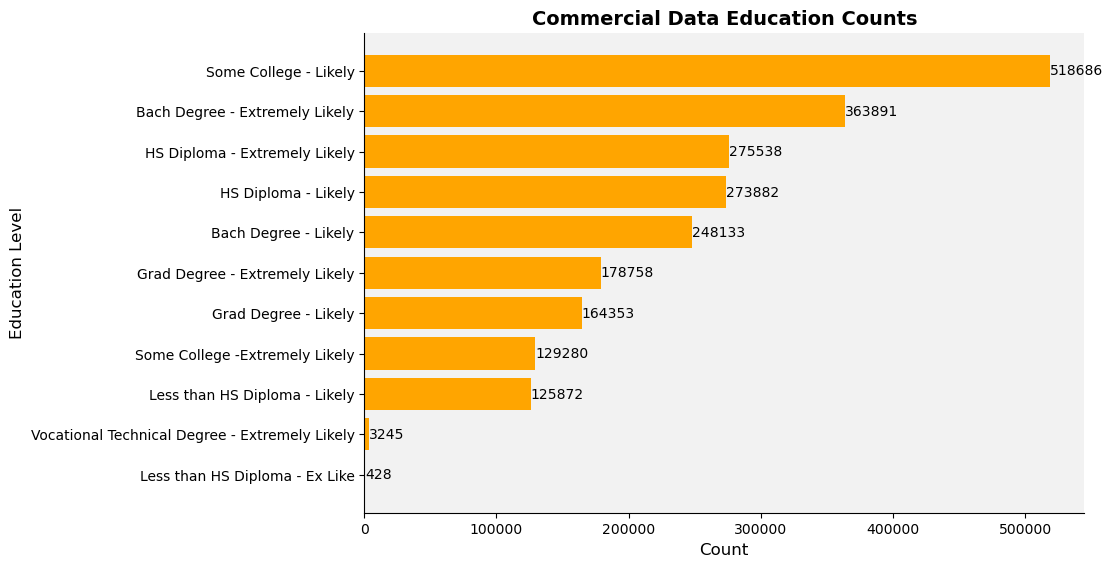

In [25]:
# convert the PySpark DataFrame to a Pandas DataFrame
dfazed_pd = dfaz.select("CommercialData_Education").toPandas()

# count the number of occurrences of each category
category_counts = dfazed_pd["CommercialData_Education"].value_counts()

# import the Matplotlib library for plotting
import matplotlib.pyplot as plt

# create a horizontal bar plot of the category counts
plt.barh(category_counts.index, category_counts.values, color="orange")

# add a title and labels to the plot
plt.title("Commercial Data Education Counts", fontsize=14, fontweight="bold")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Education Level", fontsize=12)

# invert the y-axis to show categories in descending order
plt.gca().invert_yaxis()

# remove the top and right spines of the plot
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# add text labels for the counts on each bar
for i, count in enumerate(category_counts.values):
    plt.text(count+10, i, str(count), va="center", fontsize=10)

# adjust the spacing between the bars and the y-axis labels
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)

# show the plot
plt.show()

### Massachusetts

In [10]:
# select some variables we are interested in from the data
df_need = dfma.select("Voters_Age",
                    "Voters_Gender",
                    "CommercialData_EstimatedHHIncomeAmount", 
                    "CommercialData_EstHomeValue",
                    "FECDonors_TotalDonationsAmount",
                    "CommercialData_Education",
                    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters")
df_need.show(10)

+----------+-------------+--------------------------------------+---------------------------+------------------------------+------------------------+---------------------------------------------------+
|Voters_Age|Voters_Gender|CommercialData_EstimatedHHIncomeAmount|CommercialData_EstHomeValue|FECDonors_TotalDonationsAmount|CommercialData_Education|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+----------+-------------+--------------------------------------+---------------------------+------------------------------+------------------------+---------------------------------------------------+
|        75|            F|                                $76957|                    $480131|                          null|                    null|                                                79%|
|        42|            M|                                $76957|                    $480131|                          null|                    null|                                           

In [15]:
# import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode
import seaborn as sns
import matplotlib.pyplot as plt

#### Turnout rate

In [14]:
# drop Null values and show statistical description 
turnout_df = df_need.select("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
turnout_df = turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))

turnout_df.describe(["ElectionReturns_G08CountyTurnoutAllRegisteredVoters"]).show()

+-------+---------------------------------------------------+
|summary|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|
+-------+---------------------------------------------------+
|  count|                                            4572639|
|   mean|                                  73.67958458999279|
| stddev|                                  4.495304314254126|
|    min|                                                 63|
|    max|                                                 81|
+-------+---------------------------------------------------+



Text(0, 0.5, 'Frequency')

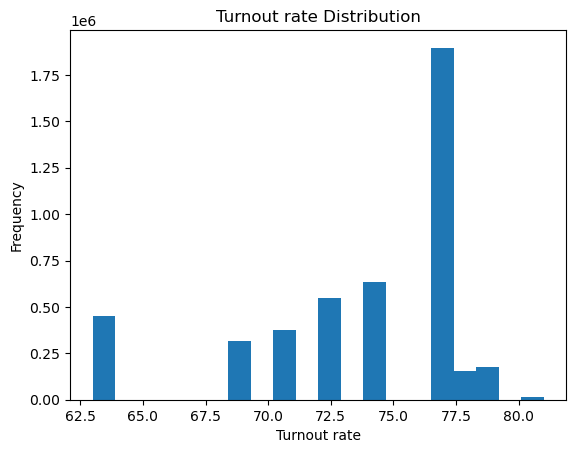

In [16]:
# Plot its distribution
data = turnout_df.sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").toPandas()
plt.hist(data, bins=20)
plt.title('Turnout rate Distribution')
plt.xlabel('Turnout rate')
plt.ylabel('Frequency')

#### Age

In [17]:
# drop Null values and show statistical description 
age_df = df_need.select("Voters_Age").na.drop()
age_df.describe(["Voters_Age"]).show()

+-------+------------------+
|summary|        Voters_Age|
+-------+------------------+
|  count|           4569645|
|   mean| 50.39094940635432|
| stddev|18.747003571724626|
|    min|                19|
|    max|               100|
+-------+------------------+



Text(0, 0.5, 'Frequency')

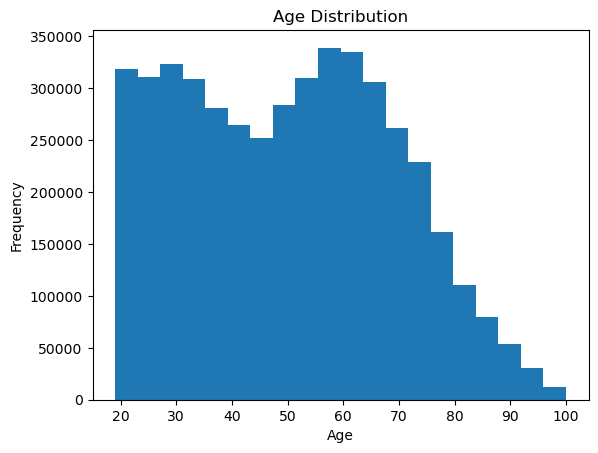

In [18]:
# Plot its distribution
data = age_df.sort("Voters_Age").toPandas()
plt.hist(data, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

In [19]:
#### Gender

In [20]:
# drop Null values and show statistical description 
sex_df = df_need.select("Voters_Gender").na.drop()
sex_df.groupBy("Voters_Gender").count().show()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|2410533|
|            M|2140564|
+-------------+-------+



Text(0, 0.5, 'Frequency')

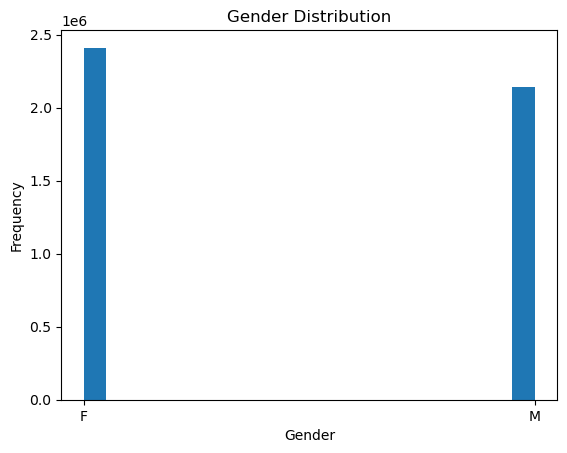

In [21]:
# Plot its distribution
data = sex_df.sort("Voters_Gender").toPandas()
plt.hist(data, bins=20)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Frequency')

#### Education level

In [23]:
# drop Null values and show statistical description 
edu_df = df_need.select("CommercialData_Education").na.drop()
edu_df.groupBy("CommercialData_Education").count().show()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Grad Degree - Ext...|358435|
|    Grad Degree - Likely|324245|
|    Bach Degree - Ext...|596976|
|     HS Diploma - Likely|293945|
|    Less than HS Dipl...|   486|
|    Some College - Li...|410362|
|    Vocational Techni...|  3676|
|    Some College -Ext...|110743|
|    HS Diploma - Extr...|414355|
|    Less than HS Dipl...|114442|
|    Bach Degree - Likely|348668|
+------------------------+------+



#### Household Income

In [24]:
# drop Null values and show statistical description 
hhincome_df = df_need.select("CommercialData_EstimatedHHIncomeAmount").na.drop()
hhincome_df = hhincome_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))

hhincome_df.describe(["CommercialData_EstimatedHHIncomeAmount"]).show()

+-------+--------------------------------------+
|summary|CommercialData_EstimatedHHIncomeAmount|
+-------+--------------------------------------+
|  count|                               4480735|
|   mean|                    119264.19954784204|
| stddev|                     66171.67859953281|
|    min|                                  6000|
|    max|                                351063|
+-------+--------------------------------------+



Text(0, 0.5, 'Frequency')

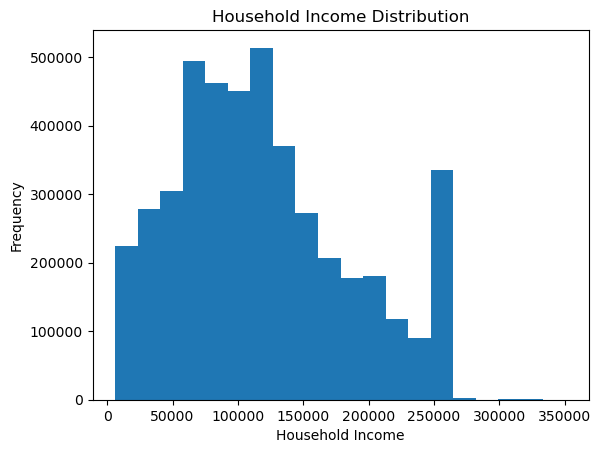

In [25]:
# Plot its distribution
data = hhincome_df.sort("CommercialData_EstimatedHHIncomeAmount").toPandas()
plt.hist(data, bins=20)
plt.title('Household Income Distribution')
plt.xlabel('Household Income')
plt.ylabel('Frequency')

#### Relationship between education level and voter turnout

In [26]:
# voter turnout by education level
education_turnout_df = df_need.select("CommercialData_Education","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
education_turnout_df = education_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
education_turnout_count = education_turnout_df.groupBy("CommercialData_Education").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")
education_turnout_count.show(10)

+------------------------+-----------------+
|CommercialData_Education|            count|
+------------------------+-----------------+
|    Less than HS Dipl...|72.34989776480663|
|    Less than HS Dipl...|73.08230452674897|
|     HS Diploma - Likely|73.51963122352821|
|    Vocational Techni...|73.54053318824809|
|    HS Diploma - Extr...|73.74269889346093|
|    Some College - Li...|73.76983248936305|
|    Bach Degree - Likely|73.92255956956187|
|    Some College -Ext...|73.94918866203733|
|    Bach Degree - Ext...|74.13399868671438|
|    Grad Degree - Likely|74.40056438803991|
+------------------------+-----------------+
only showing top 10 rows



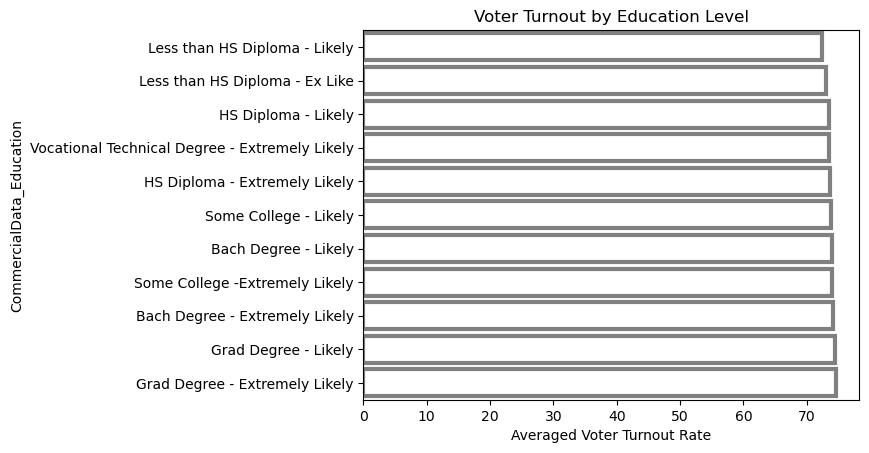

In [28]:
sns.barplot(data=education_turnout_count.toPandas(), x="count", y="CommercialData_Education",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Education Level")
plt.xlabel('Averaged Voter Turnout Rate')
plt.show()

#### Relationship between HH income and voter turnout

In [31]:
hhincome_turnout_df = df_need.select("CommercialData_EstimatedHHIncomeAmount","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
hhincome_turnout_df = hhincome_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
hhincome_turnout_df = hhincome_turnout_df.withColumn("CommercialData_EstimatedHHIncomeAmount", expr("substring(CommercialData_EstimatedHHIncomeAmount, 2, length(CommercialData_EstimatedHHIncomeAmount))").cast(IntegerType()))
hhincome_turnout_count = hhincome_turnout_df.groupBy("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").agg(avg("CommercialData_EstimatedHHIncomeAmount").alias("count")).sort("ElectionReturns_G08CountyTurnoutAllRegisteredVoters")


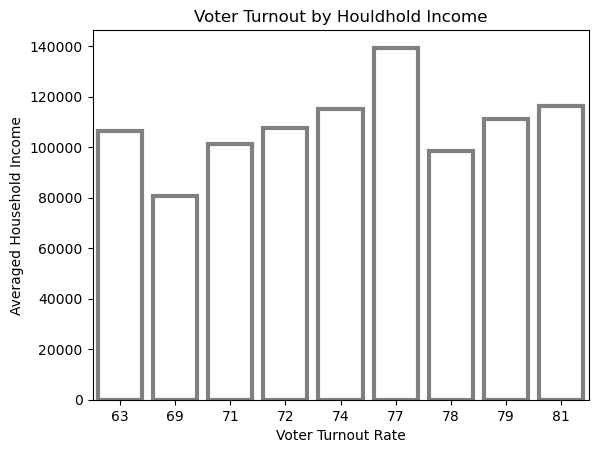

In [32]:
sns.barplot(data=hhincome_turnout_count.toPandas(), x="ElectionReturns_G08CountyTurnoutAllRegisteredVoters", y="count",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))
plt.title("Voter Turnout by Houldhold Income")
plt.xlabel('Voter Turnout Rate')
plt.ylabel('Averaged Household Income')
plt.show()

#### Relationship between age+gender with voter turnout

In [34]:
age_sex_turnout_df = df_need.select("Voters_Age","Voters_Gender","ElectionReturns_G08CountyTurnoutAllRegisteredVoters").na.drop()
age_sex_turnout_df = age_sex_turnout_df.withColumn("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", regexp_replace("ElectionReturns_G08CountyTurnoutAllRegisteredVoters", "%", "").cast(IntegerType()))
age_sex_turnout_count = age_sex_turnout_df.groupBy("Voters_Age","Voters_Gender").agg(avg("ElectionReturns_G08CountyTurnoutAllRegisteredVoters").alias("count")).sort("count")

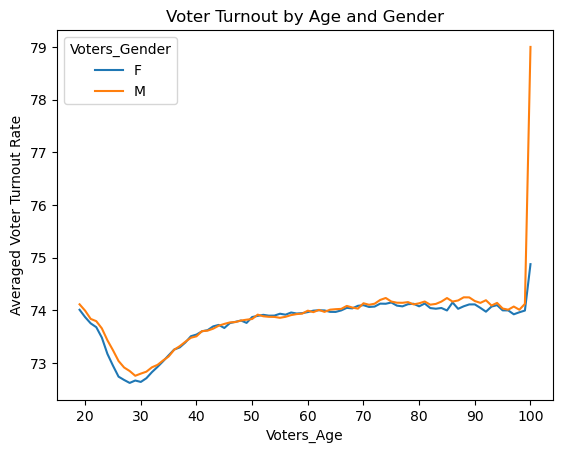

In [35]:
sns.lineplot(data=age_sex_turnout_count.toPandas(), x="Voters_Age", y="count", hue="Voters_Gender")
plt.title("Voter Turnout by Age and Gender")
plt.ylabel('Averaged Voter Turnout Rate')
plt.show()

### North Dakota

In [36]:
dfnd.select(
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters", 
    "EthnicGroups_EthnicGroup1Desc", "CountyEthnic_LALEthnicCode"
).show(5)

+---------------------------------------------------+-----------------------------+--------------------------+
|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|EthnicGroups_EthnicGroup1Desc|CountyEthnic_LALEthnicCode|
+---------------------------------------------------+-----------------------------+--------------------------+
|                                                56%|                     European|                      null|
|                                                56%|                     European|                      null|
|                                                56%|                         null|                      null|
|                                                56%|                         null|                      null|
|                                                56%|                     European|                      null|
+---------------------------------------------------+-----------------------------+--------------------------+
o

In [38]:
print(f"Before dropna, there are {dfnd.count()} records. \n")
print(f"After dropna, there are {dfnd.dropna().count()} records.")

Before dropna, there are 422720 records. 



23/02/22 06:23:03 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


After dropna, there are 0 records.


You cannot simply apply dropna to the whole dataframe

In [39]:
ethnicgp_count_nd_df = dfnd.select("EthnicGroups_EthnicGroup1Desc") \
    .dropna() \
    .groupby("EthnicGroups_EthnicGroup1Desc") \
    .count()

ethnicgp_count_nd_df.show(truncate=False)

+-----------------------------+------+
|EthnicGroups_EthnicGroup1Desc|count |
+-----------------------------+------+
|East and South Asian         |3998  |
|European                     |334609|
|Other                        |7515  |
|Likely African-American      |922   |
|Hispanic and Portuguese      |8096  |
+-----------------------------+------+



In [40]:
ethnicgp_count_nd_pddf = ethnicgp_count_nd_df.toPandas()
ethnicgp_count_nd_pddf

,EthnicGroups_EthnicGroup1Desc,count
0,East and South Asian,3998
1,European,334609
2,Other,7515
3,Likely African-American,922
4,Hispanic and Portuguese,8096


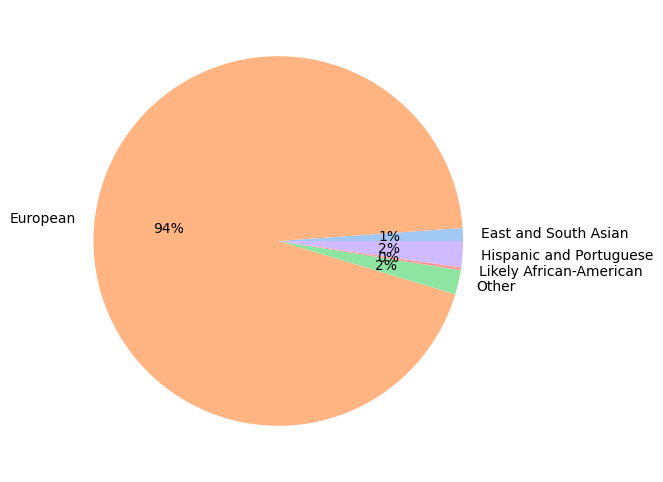

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('pastel')[0:5]
ax.pie(
    ethnicgp_count_nd_pddf['count'], 
    labels=ethnicgp_count_nd_pddf['EthnicGroups_EthnicGroup1Desc'], 
    colors=colors, autopct='%.0f%%'
)
plt.show()

LALVOTERID: Permanent and unique ID generated by L2 for a single voter 

ElectionReturns_G08CountyTurnoutAllRegisteredVoters: County percentage of voters having voted in specified election

In [42]:
g08_turnout_count_nd_df = dfnd.select("ElectionReturns_G08CountyTurnoutAllRegisteredVoters") \
    .dropna() \
    .groupby("ElectionReturns_G08CountyTurnoutAllRegisteredVoters") \
    .count()

g08_turnout_count_nd_df.show(truncate=False)

+---------------------------------------------------+------+
|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|count |
+---------------------------------------------------+------+
|54%                                                |76256 |
|45%                                                |20822 |
|57%                                                |7737  |
|36%                                                |2696  |
|49%                                                |4752  |
|34%                                                |7930  |
|58%                                                |3168  |
|55%                                                |4908  |
|47%                                                |49336 |
|44%                                                |41831 |
|60%                                                |881   |
|56%                                                |8419  |
|51%                                                |20580 |
|67%                    

In [43]:
dfnd.select(
    "Residence_Addresses_Property_LandSq_Footage", "Residence_Addresses_Property_HomeSq_Footage"
).dropna().show(5, truncate=False)

+-------------------------------------------+-------------------------------------------+
|Residence_Addresses_Property_LandSq_Footage|Residence_Addresses_Property_HomeSq_Footage|
+-------------------------------------------+-------------------------------------------+
|6503000                                    |1200                                       |
|6503000                                    |1200                                       |
|391000                                     |600                                        |
|391000                                     |600                                        |
|391000                                     |600                                        |
+-------------------------------------------+-------------------------------------------+
only showing top 5 rows



In [46]:
voters_df = dfnd.select(
    "LALVOTERID", "Voters_FirstName", "Voters_LastName", 
    "Residence_Addresses_Longitude", "Residence_Addresses_Latitude", 
    "Residence_Addresses_Property_HomeSq_Footage"
) \
    .dropna()

print(f"voters_df has {voters_df.count()} records.")
voters_df.show(5, truncate=False)

voters_df has 165732 records.
+--------------+----------------+---------------+-----------------------------+----------------------------+-------------------------------------------+
|LALVOTERID    |Voters_FirstName|Voters_LastName|Residence_Addresses_Longitude|Residence_Addresses_Latitude|Residence_Addresses_Property_HomeSq_Footage|
+--------------+----------------+---------------+-----------------------------+----------------------------+-------------------------------------------+
|LALND462587305|Gena            |Ertelt         |-97.828399                   |46.918498                   |1200                                       |
|LALND15911    |Jeffrey         |Ertelt         |-97.828399                   |46.918498                   |1200                                       |
|LALND21339    |Karen           |Anderson       |-97.788869                   |47.081127                   |600                                        |
|LALND504885535|William         |Anderson       |-97

In [47]:
voters_pddf = voters_df.toPandas()
voters_pddf.head()

,LALVOTERID,Voters_FirstName,Voters_LastName,Residence_Addresses_Longitude,Residence_Addresses_Latitude,Residence_Addresses_Property_HomeSq_Footage
0,LALND462587305,Gena,Ertelt,-97.828399,46.918498,1200
1,LALND15911,Jeffrey,Ertelt,-97.828399,46.918498,1200
2,LALND21339,Karen,Anderson,-97.788869,47.081127,600
3,LALND504885535,William,Anderson,-97.788869,47.081127,600
4,LALND504885655,Kayla,Anderson,-97.788869,47.081127,600


In [49]:
# Exploratory Spatial Data Analysis
import esda  # https://pysal.org/esda/index.html
from shapely.geometry import Point
import geopandas as gpd

In [50]:
# geodataframe of voters
geometry = [
    Point(xy) for xy in zip(
        voters_pddf["Residence_Addresses_Longitude"], 
        voters_pddf["Residence_Addresses_Latitude"]
    )
]
voters_gdf = gpd.GeoDataFrame(
    voters_pddf, crs="EPSG:4326", geometry=geometry
)

In [72]:
data_path = "gs://pstat235-sk/"

In [54]:
# load us.counties csv
us_counties_df = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat135-voter-file/uscounties.csv")

In [55]:
import os
import pickle

In [73]:
# read shapefiles
counties_gpd = gpd.read_file(
    os.path.join(
        data_path, "shp/Counties.shp"
    )
)

print(f"Number of records in counties_gpd: {len(counties_gpd)}")
counties_gpd.head()

Number of records in counties_gpd: 3141


,ObjectID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POP2000,POP2004,POP00_SQMI,POP04_SQMI,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS97,AVG_SIZE97,CROP_ACR97,AVG_SALE97,SQMI,geometry
0,0,Gallatin,Montana,30,031,30031,67831,74167,25.8,28.2,...,29489,3166,16434,9889,835,910,252837,70.55,2632.2,"POLYGON ((-111.37231 44.74509, -111.36918 45.3..."
1,1,Monroe,Florida,12,087,12087,79589,80976,79.8,81.2,...,51617,16531,21893,13193,13,95,0,0.00,997.2,"MULTIPOLYGON (((-81.25621 25.80310, -80.87454 ..."
2,2,Kalawao,Hawaii,15,005,15005,147,143,11.2,10.8,...,172,57,0,115,-99,-99,-99,-99.00,13.2,"POLYGON ((-156.91021 21.15805, -156.89743 21.1..."
3,3,Kauai,Hawaii,15,007,15007,58463,60165,93.2,95.9,...,25331,5148,12384,7799,468,421,0,122.81,627.3,"MULTIPOLYGON (((-159.33518 21.94834, -159.4395..."
4,4,Honolulu,Hawaii,15,003,15003,876156,894358,1461.9,1492.3,...,315988,29538,156290,130160,880,91,29237,162.46,599.3,"POLYGON ((-157.67333 21.29803, -157.68137 21.2..."


In [74]:
nd_counties_gpd = counties_gpd.loc[counties_gpd["STATE_NAME"] == "North Dakota"]

print(f"Number of records in nd_counties_gpd: {len(nd_counties_gpd)}")
nd_counties_gpd.head()

Number of records in nd_counties_gpd: 53


,ObjectID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POP2000,POP2004,POP00_SQMI,POP04_SQMI,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS97,AVG_SIZE97,CROP_ACR97,AVG_SALE97,SQMI,geometry
149,149,Ward,North Dakota,38,101,38101,58795,57939,28.6,28.2,...,25097,2056,14434,8607,1172,1030,949278,70.74,2056.5,"POLYGON ((-100.96471 47.85409, -101.87778 47.8..."
150,150,McLean,North Dakota,38,055,38055,9311,8994,4.0,3.9,...,5264,1449,3135,680,969,1179,866193,76.65,2327.8,"POLYGON ((-101.26044 47.26665, -101.28171 47.2..."
151,151,Williams,North Dakota,38,105,38105,19761,19276,9.2,9.0,...,9680,1585,5778,2317,850,1418,829313,62.38,2148.0,"POLYGON ((-102.82546 48.12738, -102.85777 48.1..."
153,153,Mercer,North Dakota,38,057,38057,8644,8520,7.8,7.7,...,4402,1056,2828,518,473,1165,283584,48.71,1112.4,"POLYGON ((-101.76554 46.98543, -102.10465 46.9..."
155,155,Golden Valley,North Dakota,38,033,38033,1924,1847,1.9,1.8,...,973,212,594,167,244,2372,221203,74.86,1002.4,"POLYGON ((-104.04671 46.54254, -104.04744 46.6..."


<AxesSubplot:>

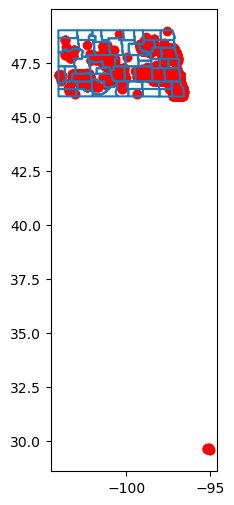

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_gpd.boundary.plot(ax=ax)
voters_gdf.plot(ax=ax, color='red')

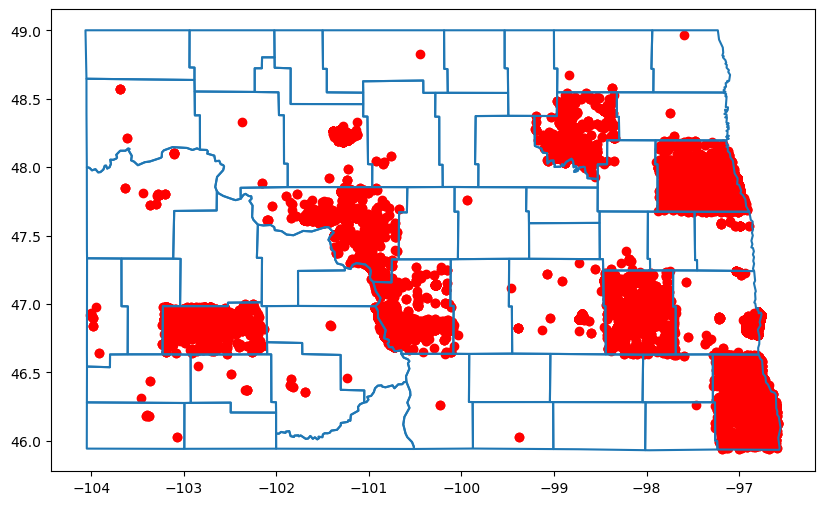

In [76]:
# remove outlier
voters_rmout_gdf = voters_gdf.loc[voters_gdf["Residence_Addresses_Latitude"] > 45]
fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_gpd.boundary.plot(ax=ax)
voters_rmout_gdf.plot(ax=ax, color='red')
plt.show()

From the figure above, it seems that the voters from this dataset are mainly clustered in several counties rather than spread across all counties in North Dakota. It is not certain whether this is because the dataset is incomplete or it somehow reflects the spatial distribution of those voters. The former seems more reasonable. If so, then we have to careful when trying to further analyze the relationship between variables since this dataset might be biased.